In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std, plot_best_worst, plot_best_worst_class_imbalance, compute_best_worst_scores, plot_methods_linreg
from pydvl.value.result import ValuationResult

from sklearn.datasets import load_iris, fetch_kddcup99, fetch_openml
import pandas as pd

In [2]:
import pandas as pd
from sklearn.datasets import load_iris

data = Dataset.from_sklearn(load_iris())

In [3]:
from sklearn.mixture import GaussianMixture

In [4]:
indexes = np.arange(100)
indexes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [5]:
import random

In [6]:
def sample_bag(indexes, max_samples):
    n_samp = int(max_samples*len(indexes))
    return(random.choices(indexes, k=n_samp))

In [7]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [8]:
from tqdm import tqdm

In [9]:

def compute_data_oob_generative(
    u: Utility,
    n_est: int = 10,
    max_samples: float = 0.8,
    progress=False
) -> ValuationResult:
    r"""
    """

    result: ValuationResult[np.int_, np.float_] = ValuationResult.empty(
        algorithm="data_oob", indices=u.data.indices, data_names=u.data.data_names
    )
    bags_indexes = [sample_bag(u.data.indices, max_samples) for _ in range(n_est)]
    
    if(progress):
        estimators_AD = [IsolationForest().fit(data.x_train[indx]) for indx in tqdm(bags_indexes)]
    else:
        estimators_AD = [IsolationForest().fit(data.x_train[indx]) for indx in bags_indexes]

    

    for est, bag_idx in zip(estimators_AD, bags_indexes):
        oob_idx = np.setxor1d(u.data.indices, bag_idx)
        array_loss = est.predict(data.x_train[oob_idx])
        result += ValuationResult(
            algorithm="data_oob",
            indices=oob_idx,
            values=array_loss,
            counts=np.ones_like(array_loss, dtype=u.data.indices.dtype),
        )

    return result
    

In [10]:
Utility(GaussianMixture(), data, Scorer('accuracy', default=0.0))
#Utility(model, data, Scorer("accuracy", default=0.0))

In [11]:
    
def compute_data_oob_generative_2(
    u: Utility,
    n_est: int = 10,
    max_samples: float = 0.8,
    progress=False
) -> ValuationResult:
    r"""
    """

    result: ValuationResult[np.int_, np.float_] = ValuationResult.empty(
        algorithm="data_oob", indices=u.data.indices, data_names=u.data.data_names
    )
    bags_indexes = [sample_bag(u.data.indices, max_samples) for _ in range(n_est)]
    
    if(progress):
        if "synthcity" in str(type(u.model)):
            estimators = [u.model.fit(GenericDataLoader(data.x_train[indx])) for indx in tqdm(bags_indexes)]    
        else:
            estimators = [u.model().fit(data.x_train[indx]) for indx in tqdm(bags_indexes)]    
    else:
        if "synthcity" in str(type(u.model)):
            estimators = [u.model.fit(GenericDataLoader(data.x_train[indx])) for indx in bags_indexes]    
        else:
            estimators = [u.model().fit(data.x_train[indx]) for indx in bags_indexes]    
        #estimators = [GaussianMixture().fit(data.x_train[indx]) for indx in bags_indexes]    

    for est, bag_idx in tqdm(zip(estimators, bags_indexes)):
        oob_idx = np.setxor1d(u.data.indices, bag_idx)
        generated_data = est.sample(200)[0]
        ad = IsolationForest().fit(generated_data)
        array_loss = np.array([ad.predict(np.array([u.data.x_train[p]]))[0] for p in oob_idx])
        
        result += ValuationResult(
            algorithm="data_oob",
            indices=oob_idx,
            values=array_loss,
            counts=np.ones_like(array_loss, dtype=u.data.indices.dtype),
        )

    return result
    

In [58]:
len(utility.data.x_test)

30

In [169]:
    
def compute_data_oob_generative_3(
    u: Utility,
    n_est: int = 10,
    max_samples: float = 0.8,
    progress=False,
    eval_alg = "OneClassSVM",
) -> ValuationResult:
    r"""
    """

    result: ValuationResult[np.int_, np.float_] = ValuationResult.empty(
        algorithm="data_oob", indices=u.data.indices, data_names=u.data.data_names
    )

    if(progress): iterator = tqdm(range(n_est))
    else: iterator = range(n_est)
    for _ in iterator:
        bag_idx = sample_bag(u.data.indices, max_samples)
        if "synthcity" in str(type(u.model)):
            est = u.model.fit(GenericDataLoader(data.x_train[bag_idx]))
        else:
            est = u.model().fit(data.x_train[bag_idx])
        oob_idx = np.setxor1d(u.data.indices, bag_idx)
        if "synthcity" in str(type(u.model)):
            generated_data = est.generate(count=30).dataframe()
        else:
            generated_data = est.sample(30)[0]
        if eval_alg=="OneClassSVM":
            ad = OneClassSVM().fit(generated_data)
        else:
            ad = IsolationForest().fit(generated_data)
        array_loss = np.array([ad.predict(np.array([u.data.x_train[p]]))[0] for p in oob_idx])
        result += ValuationResult(
            algorithm="data_oob",
            indices=oob_idx,
            values=array_loss,
            counts=np.ones_like(array_loss, dtype=u.data.indices.dtype),
        )
        
    return result
    

In [170]:

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader

In [171]:


#model = KNeighborsClassifier(n_neighbors=5)
#model = DecisionTreeClassifier(max_depth=5,)
#model = LogisticRegression()
model = GaussianMixture
#model = Plugins().get("ctgan")

utility = Utility(model, data, Scorer("accuracy", default=0.0))

In [172]:
oob_values = compute_data_oob_generative_3(utility, progress=True, max_samples=0.2, n_est=300, eval_alg="LogisticDetection")

100%|██████████| 300/300 [02:38<00:00,  1.89it/s]


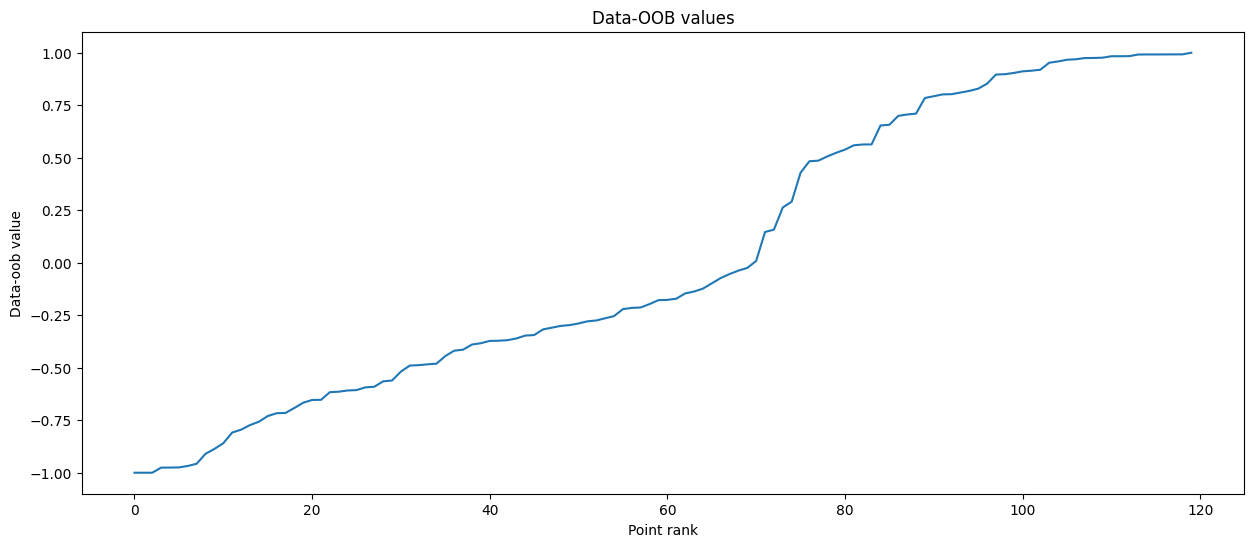

In [173]:
oob_values.sort(key="value")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 6])

ax.plot(np.arange(len(oob_values.values)), oob_values.values)
ax.set_title("Data-OOB values")
ax.set_ylabel("Data-oob value")
ax.set_xlabel("Point rank");

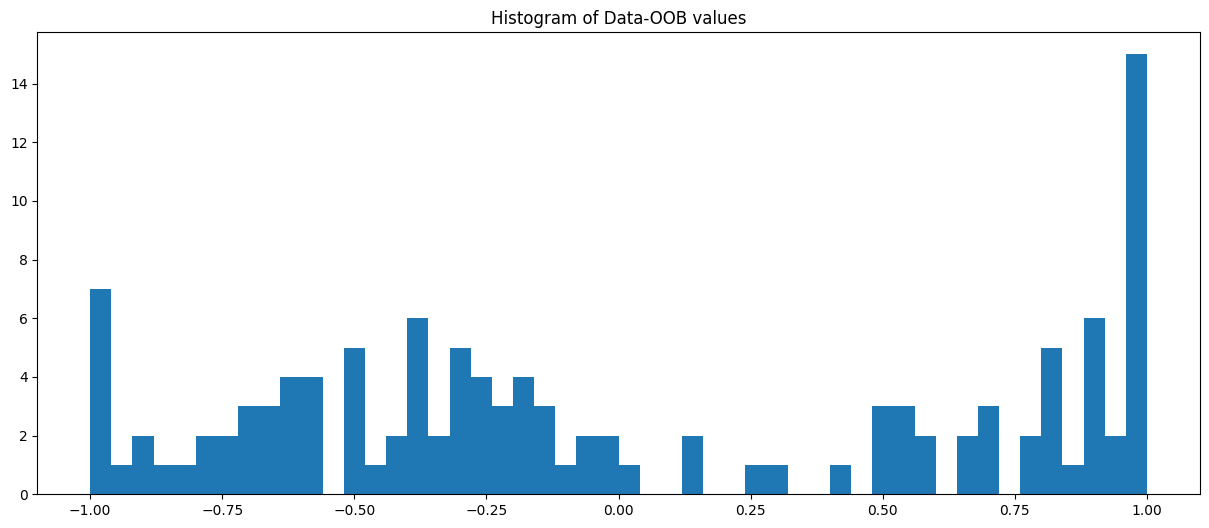

In [174]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 6])
ax.hist(oob_values.values, bins=50)
ax.set_title("Histogram of Data-OOB values");

In [175]:
utility.data.x_train[:,1].shape, oob_values.values.shape

((120,), (120,))

In [176]:
oob_values.to_dataframe()["data_oob"]

76   -1.000000
55   -1.000000
24   -1.000000
39   -0.975709
86   -0.975510
        ...   
10    0.991770
11    0.991837
97    0.992095
0     0.992126
37    1.000000
Name: data_oob, Length: 120, dtype: float64

In [177]:
df = pd.DataFrame(utility.data.x_train, columns=utility.data.feature_names)
df.loc[:,"values"] = oob_values.to_dataframe()["data_oob"]
df.loc[:,"values"].fillna(1)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),values
0,5.7,2.9,4.2,1.3,0.992126
1,6.2,2.9,4.3,1.3,0.983740
2,5.6,3.0,4.5,1.5,0.983193
3,6.2,3.4,5.4,2.3,-0.560976
4,4.3,3.0,1.1,0.1,-0.909836
...,...,...,...,...,...
115,6.3,2.5,4.9,1.5,0.428571
116,5.1,3.8,1.6,0.2,-0.715415
117,6.9,3.1,5.1,2.3,-0.346939
118,7.3,2.9,6.3,1.8,-0.773279


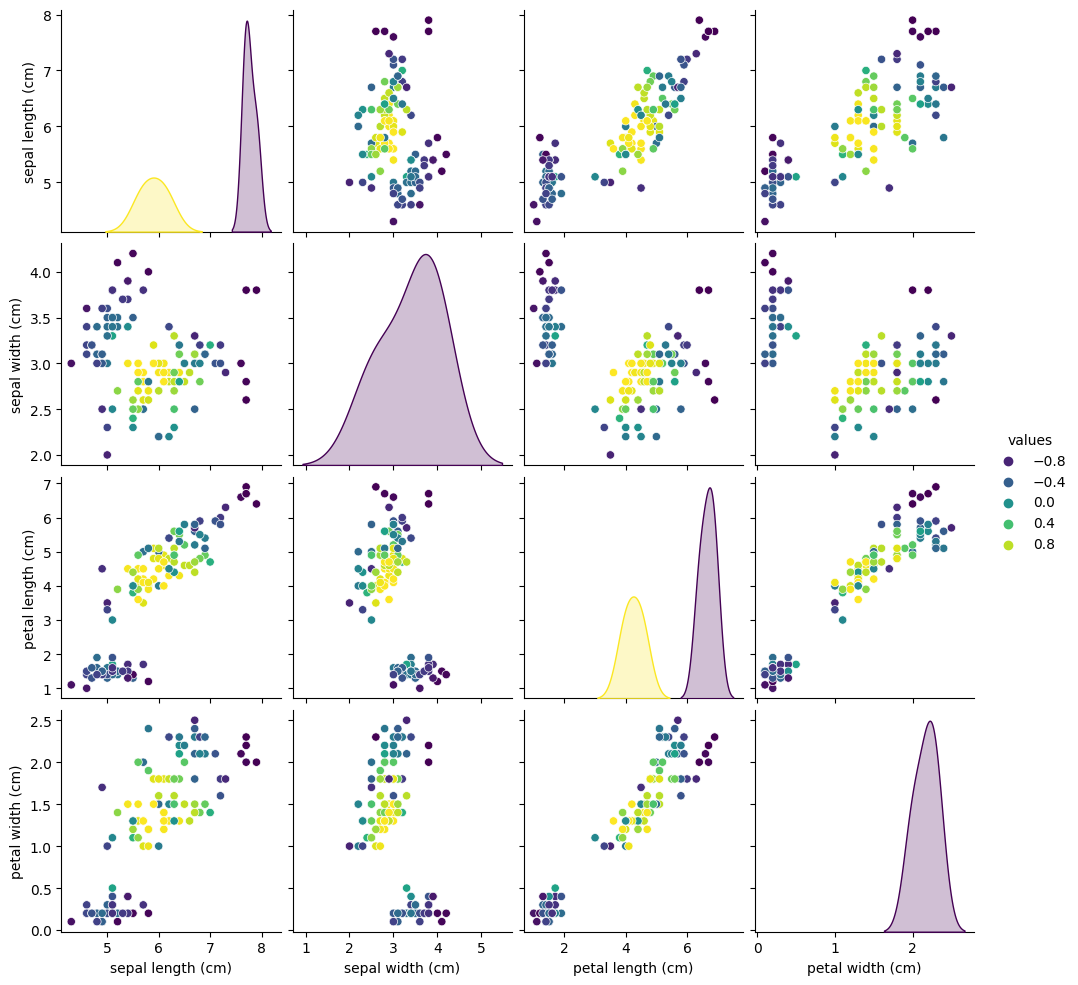

In [178]:
sns.pairplot(data=df, hue="values", palette="viridis")

<Axes: >

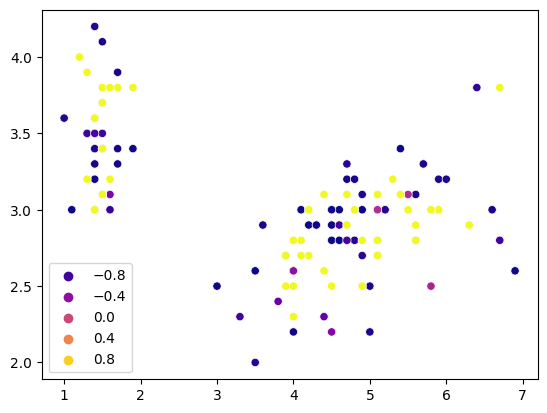

In [22]:
sns.scatterplot(x = utility.data.x_train[:,2], y=utility.data.x_train[:,1], hue =[x if x<-0.1 else 1 for x in oob_values.values], palette='plasma')

## Variance

The variance it the weak learner variance. It is computed with Welford's online algorithm.

In [23]:
plot_list = [(a, b) for a, b in zip(oob_values.values, oob_values.variances)]
plot_list = pd.DataFrame(plot_list).sample(100).sort_values(by=0).values
yerr = [x[1] ** 2 for x in plot_list]

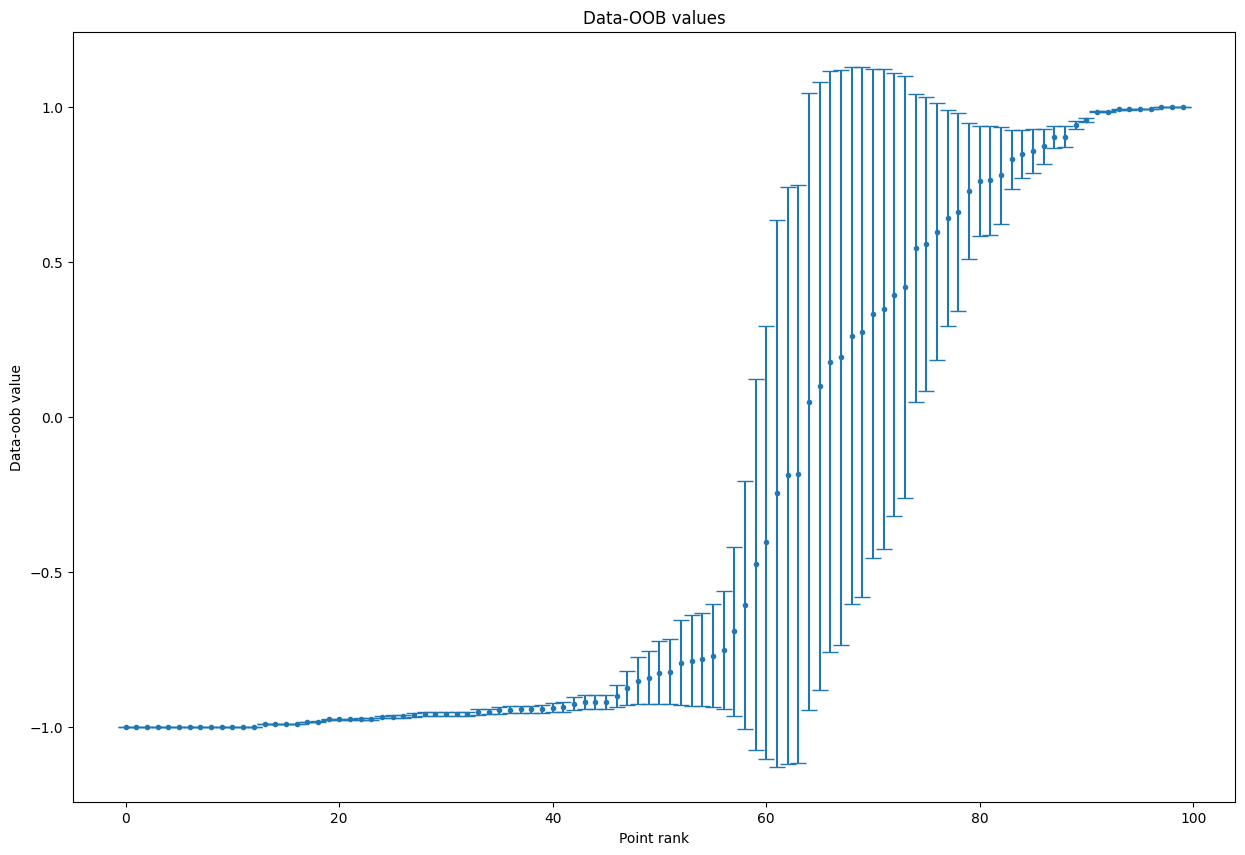

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 10])
ax.errorbar(
    x=np.arange(len(yerr)), y=[x[0] for x in plot_list], yerr=yerr, fmt=".", capsize=6
)
plt.title("Data-OOB values")
ax.set_ylabel("Data-oob value")
ax.set_xlabel("Point rank");

In [25]:
from pydvl.reporting.plots import compute_best_worst_scores, plot_best_worst_class_imbalance

In [26]:
def oob_func(utility, n_est):
    return(compute_data_oob_generative(utility, n_est=n_est, max_samples=0.4, progress=True))
n_est_list = [10, 20, 30]
func = oob_func
kwargs_list = [{"n_est":n_est} for n_est in n_est_list]

In [27]:
model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

100%|██████████| 30/30 [00:07<00:00,  3.89it/s]


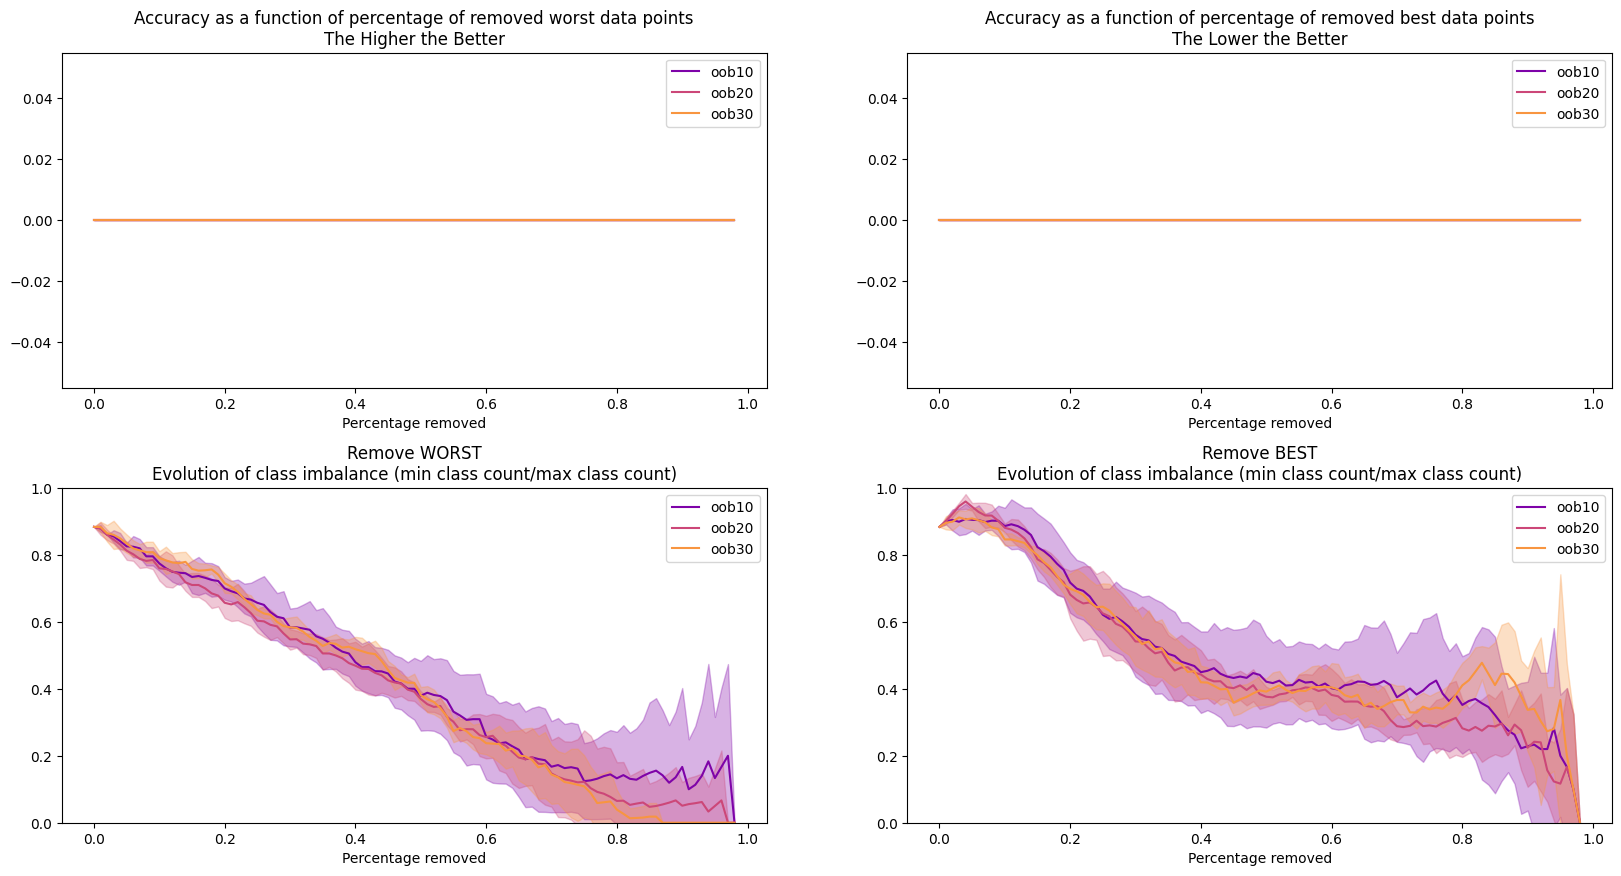

In [28]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility, palette_name="plasma")

# Eval 

## Removal based metric:

In [74]:
model_class = GaussianMixture
m = model_class()

In [232]:
from sdmetrics.single_table import SVCDetection, CorrelationSimilarity, LogisticDetection, KSComplement, StatisticSimilarity, BoundaryAdherence
from sdv.metrics.tabular import BinaryDecisionTreeClassifier

In [277]:
from typing import Dict, Iterable, Union
from pydvl.utils import Utility, maybe_progress
from numpy.typing import NDArray

def compute_gen_scores(
    u: Utility,
    values: ValuationResult,
    percentages: Union[NDArray[np.float_], Iterable[float]],
    *,
    remove_best: bool = False,
    metric,
    progress: bool = False,
) -> Dict[float, float]:
    
    # Sanity checks
    if np.any([x >= 1.0 or x < 0.0 for x in percentages]):
        raise ValueError("All percentages should be in the range [0.0, 1.0)")

    if len(values) != len(u.data.indices):
        raise ValueError(
            f"The number of values, {len(values) }, should be equal to the number of data indices, {len(u.data.indices)}"
        )

    scores = {}
    classes = np.unique(u.data.y_train)
    # We sort in descending order if we want to remove the best values
    values.sort(reverse=remove_best)
    all_gen_scores = []
    for pct in maybe_progress(percentages, display=progress, desc="Removal Scores"):
        n_removal = int(pct * len(u.data))
        indices = values.indices[n_removal:]
        train_data = u.data.x_train[indices]
        synth_data = m().fit(train_data).sample(30)[0]
        score = metric.compute(
                            real_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
                            synthetic_data=pd.DataFrame(synth_data, columns = data.feature_names),
                        )
        all_gen_scores.append(score)
    return pd.DataFrame(all_gen_scores, index = percentages, columns=[metric.__name__])


In [278]:
values = df.sort_values(ascending=False, by="values").loc[:,"values"].values

In [308]:
all_results = pd.DataFrame([])
n_iter = 2
for _ in range(n_iter):
    for metric in metric_list:
        res = compute_gen_scores(
            u= utility,
            values= ValuationResult(values=values),
            percentages= percentages,
            metric=metric,
        ) 
        all_results = pd.concat((all_results, res), axis=1)


all_results = all_results.T.reset_index().rename(columns={"index":"method_name"})
all_results.loc[:, "method_name"] = all_results.loc[:, "method_name"].apply(lambda x: "_"+x)

In [309]:
all_results

,method_name,0.0,0.05,0.1,0.15000000000000002,0.2,0.25,0.30000000000000004,0.35000000000000003,0.4,...,0.5,0.55,0.6000000000000001,0.65,0.7000000000000001,0.75,0.8,0.8500000000000001,0.9,0.9500000000000001
0,_SVCDetection,0.793333,0.723333,0.563333,0.906667,0.813333,0.760000,0.780000,0.986667,1.000000,...,0.840000,1.000000,0.553333,0.866667,0.473333,1.000000,0.453333,0.913333,0.306667,0.340000
1,_CorrelationSimilarity,0.902745,0.940653,0.928779,0.857791,0.862974,0.886221,0.884402,0.920624,0.908603,...,0.899077,0.907818,0.890894,0.907861,0.898330,0.914968,0.968287,0.946830,0.868027,0.858491
2,_LogisticDetection,0.966667,0.966667,1.000000,1.000000,0.673333,0.920000,1.000000,1.000000,0.993333,...,1.000000,0.840000,1.000000,0.980000,0.833333,0.960000,0.940000,0.773333,0.813333,0.773333
3,_KSComplement,0.766667,0.733333,0.750000,0.775000,0.733333,0.758333,0.741667,0.783333,0.750000,...,0.758333,0.708333,0.741667,0.808333,0.783333,0.775000,0.683333,0.700000,0.658333,0.650000
4,_StatisticSimilarity,0.930158,0.973646,0.951716,0.947059,0.897362,0.971461,0.931451,0.961771,0.971111,...,0.844205,0.931335,0.918612,0.965669,0.978485,0.981513,0.959948,0.950405,0.947487,0.965879
5,_BoundaryAdherence,0.925000,0.891667,0.883333,0.991667,0.891667,0.900000,0.925000,0.858333,0.858333,...,0.925000,0.975000,0.891667,0.883333,0.916667,0.883333,0.975000,0.983333,0.966667,0.925000
6,_SVCDetection,0.553333,0.920000,0.553333,0.653333,0.393333,0.920000,0.800000,0.926667,0.626667,...,0.746667,0.800000,0.760000,0.493333,0.973333,0.466667,0.226667,0.833333,0.500000,0.273333
7,_CorrelationSimilarity,0.939493,0.973639,0.952695,0.903897,0.877646,0.921485,0.942721,0.942805,0.886716,...,0.910692,0.861738,0.923253,0.891442,0.878555,0.954813,0.914867,0.947966,0.843569,0.831816
8,_LogisticDetection,0.826667,1.000000,0.960000,1.000000,1.000000,0.993333,0.893333,1.000000,0.840000,...,0.800000,0.933333,1.000000,0.906667,0.746667,0.800000,0.873333,0.993333,0.733333,0.646667
9,_KSComplement,0.741667,0.783333,0.816667,0.750000,0.766667,0.716667,0.791667,0.791667,0.783333,...,0.766667,0.783333,0.750000,0.741667,0.733333,0.700000,0.658333,0.741667,0.675000,0.733333


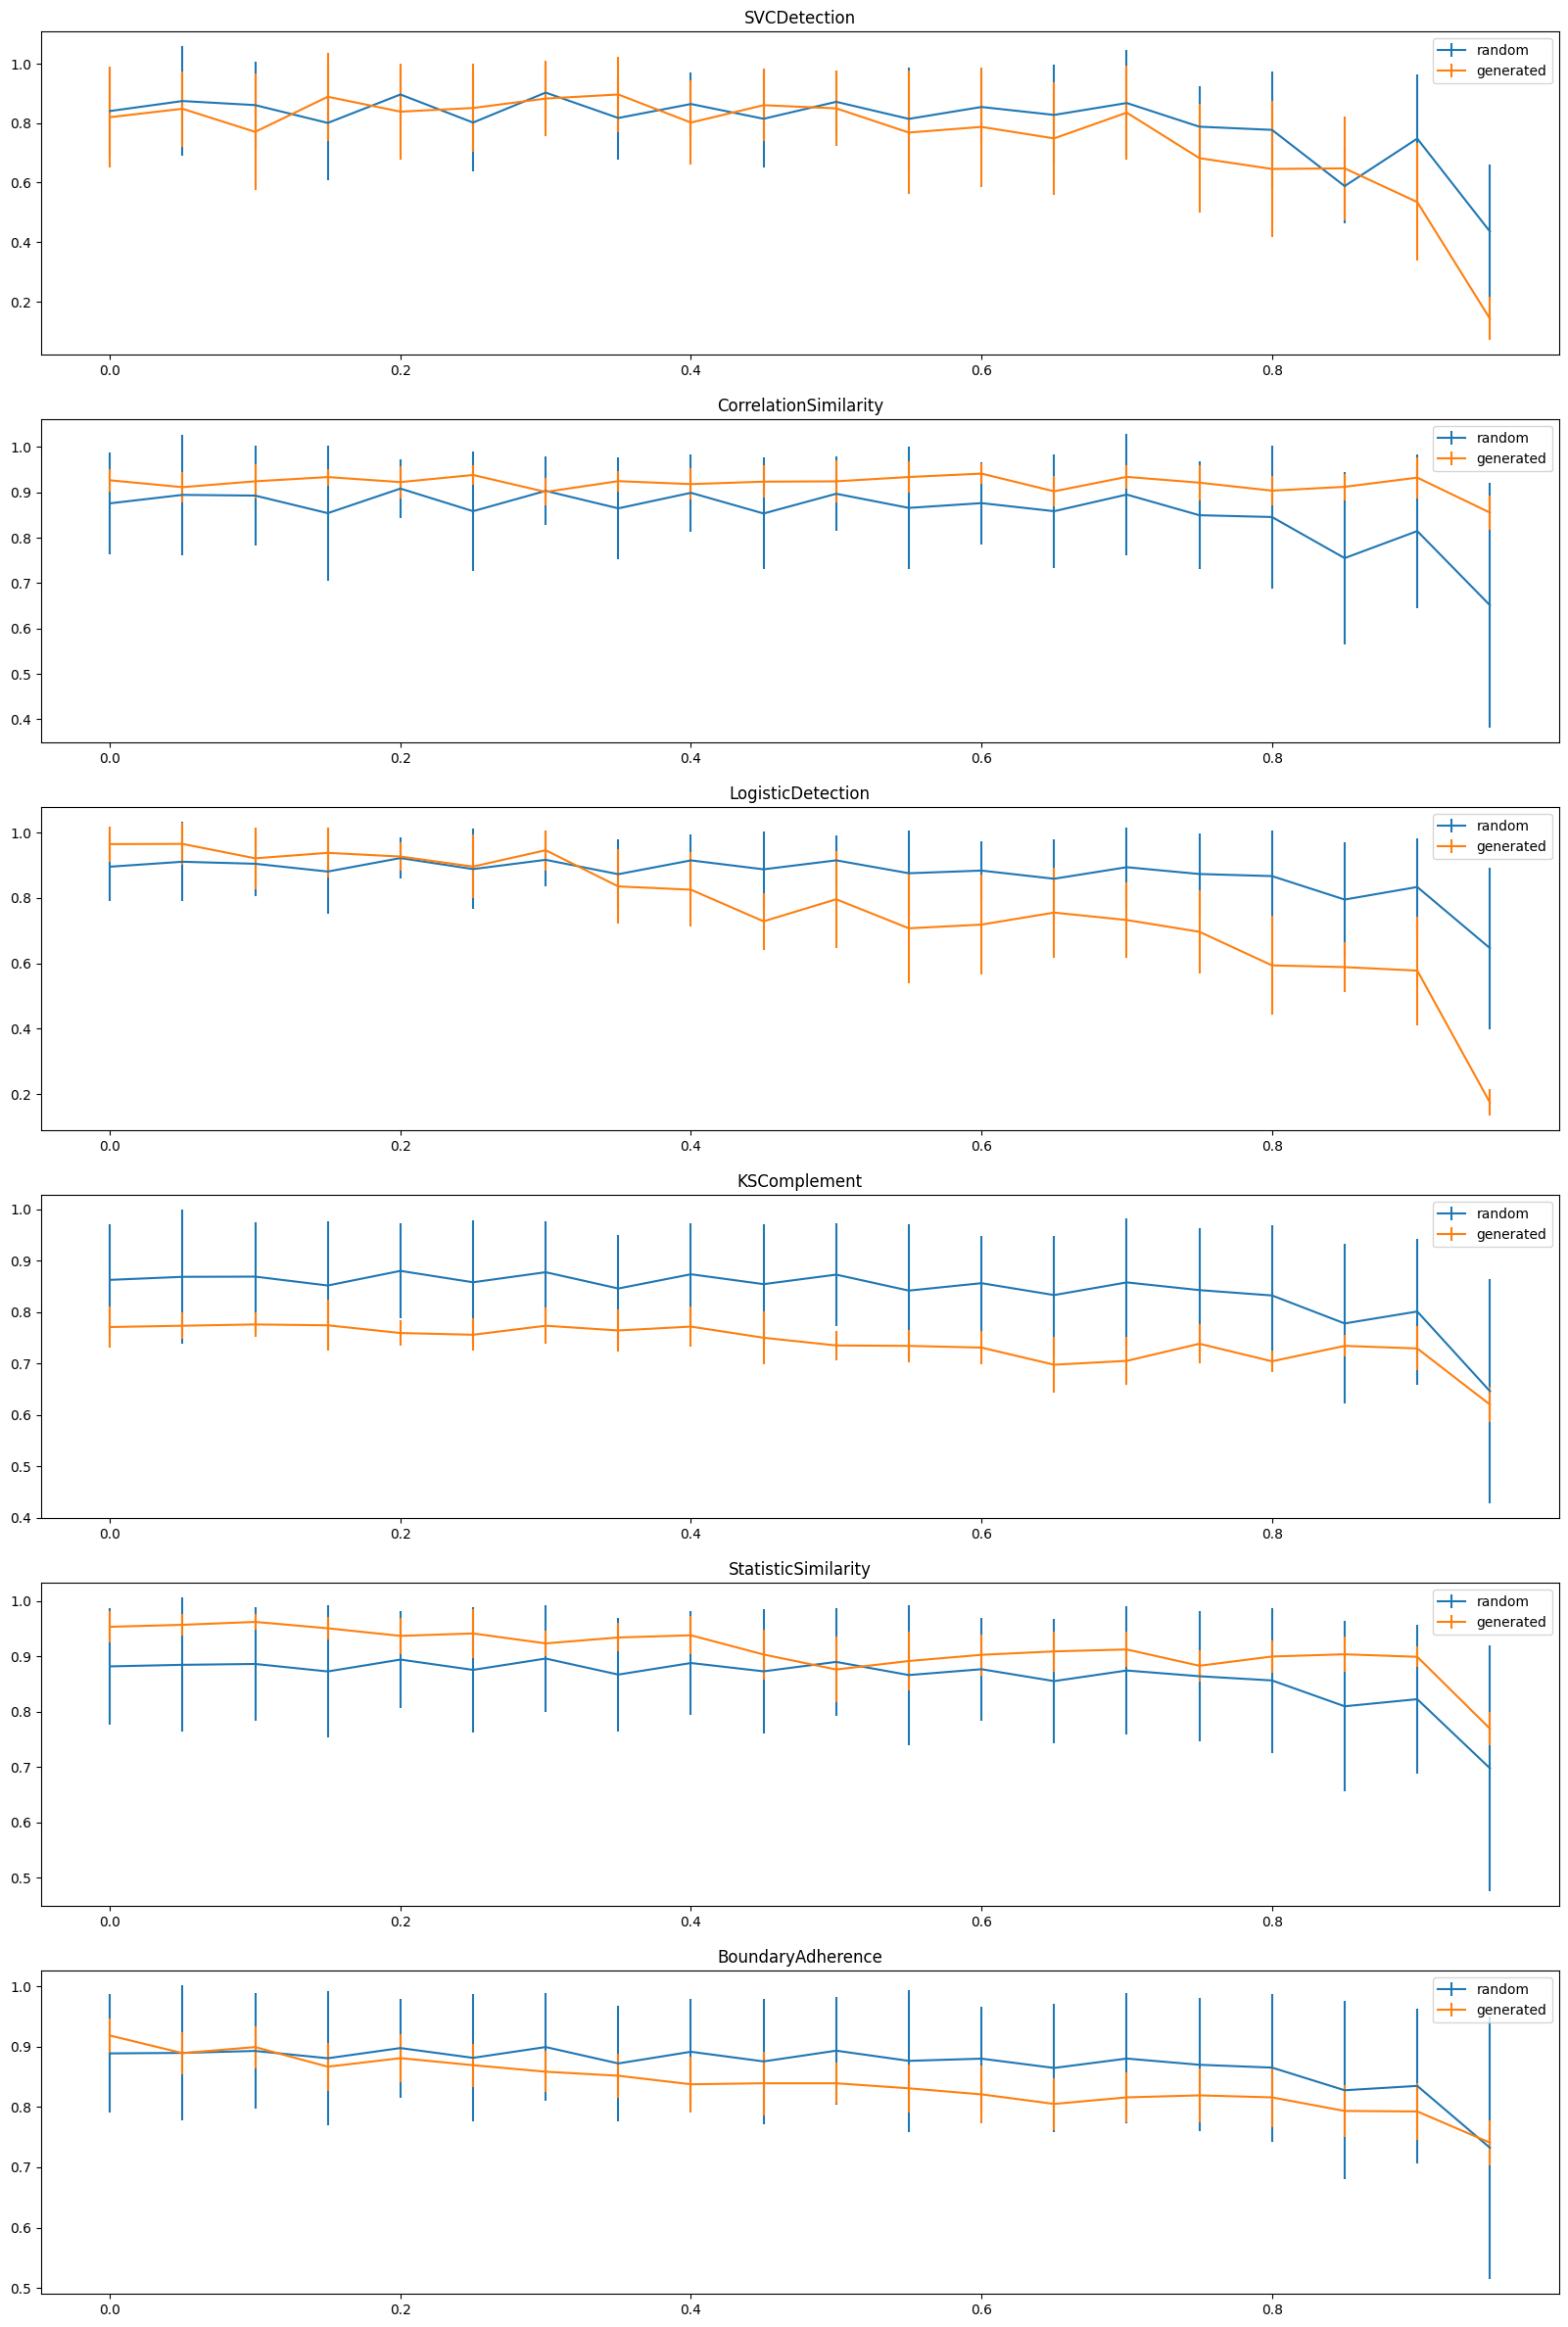

In [236]:
m = GaussianMixture
sorted_df = df.sort_values(ascending=False, by="values").drop(columns = ['values'])
n_iter=10
n_iter_random=10
metric_list = [SVCDetection, CorrelationSimilarity, LogisticDetection, KSComplement, StatisticSimilarity, BoundaryAdherence]

percentages = np.arange(0, 0.90, 0.05)

fig, ax = plt.subplots(ncols=1, nrows = len(metric_list), figsize = [20,5*len(metric_list)])

random_score = {pct:[] for pct in percentages}

for i,metric in enumerate(metric_list):
    for pct in percentages:
        for k in range(n_iter_random):
            n_removal = int(pct * len(sorted_df))
            train_data = sorted_df.sample(int(len(sorted_df)-n_removal))#.iloc[n_removal:]
            model = m().fit(train_data)
            gen_data = model.sample(30)[0]
            
            score = metric.compute(
                    real_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
                    synthetic_data=pd.DataFrame(gen_data, columns = data.feature_names),
                )
            random_score[pct].append(score)
    
    ax[i].errorbar(x=percentages,y=[np.mean(x) for k,x in random_score.items()],
                        yerr=[np.std(x) for k,x in random_score.items()], label='random')

for i,metric in enumerate(metric_list):
    all_scores = {pct:[] for pct in percentages}
    for pct in percentages:
        n_removal = int(pct * len(sorted_df))
        train_data = sorted_df.iloc[n_removal:]
        model = m().fit(train_data)
        for k in range(n_iter):
            gen_data = model.sample(30)plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility, palette_name="plasma")
                    real_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
                    synthetic_data=pd.DataFrame(gen_data, columns = data.feature_names),
                )
            all_scores[pct].append(score)
    ax[i].errorbar(x=percentages,y=[np.mean(x) for k,x in all_scores.items()],
                    yerr=[np.std(x) for k,x in all_scores.items()], label='generated')
    ax[i].set_title(metric.__name__)
    ax[i].legend()
plt.show()

In [252]:
best_scores_df = pd.DataFrame(all_scores)
best_scores_df.loc[:,"method_name"] = "_oob"

df_random = pd.DataFrame(random_score)
df_random.loc[:,"method_name"] = "_random"
best_scores_df = pd.concat((best_scores_df, df_random))

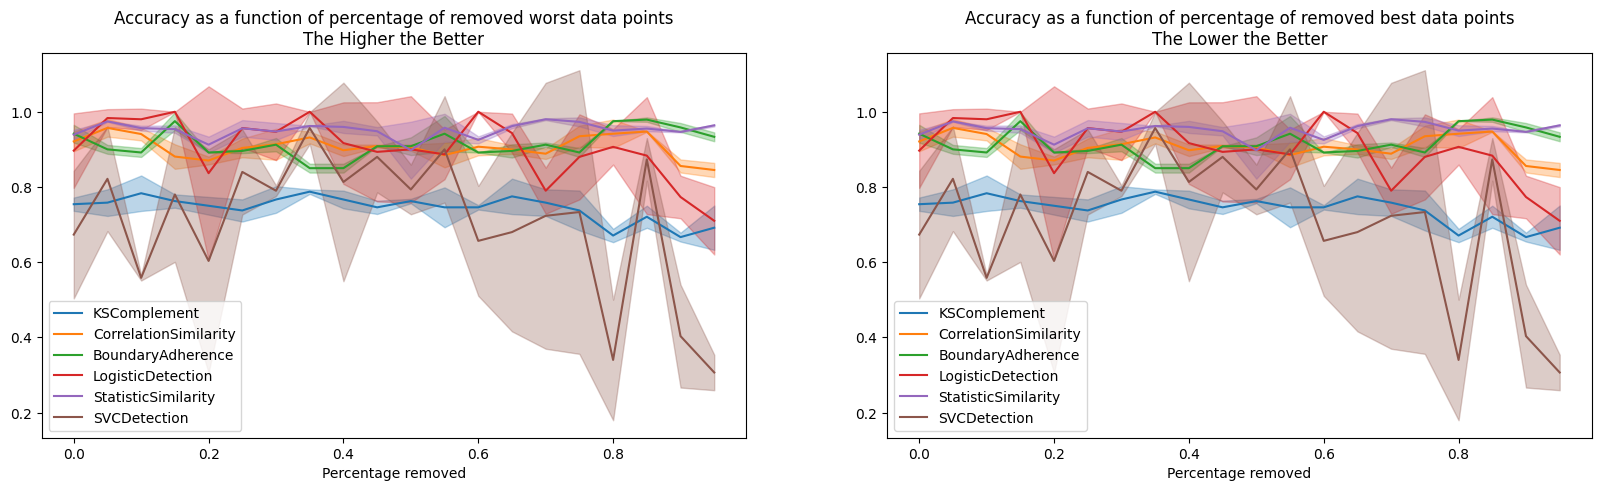

In [310]:
plot_best_worst(all_results, all_results)

### Reverse the order 

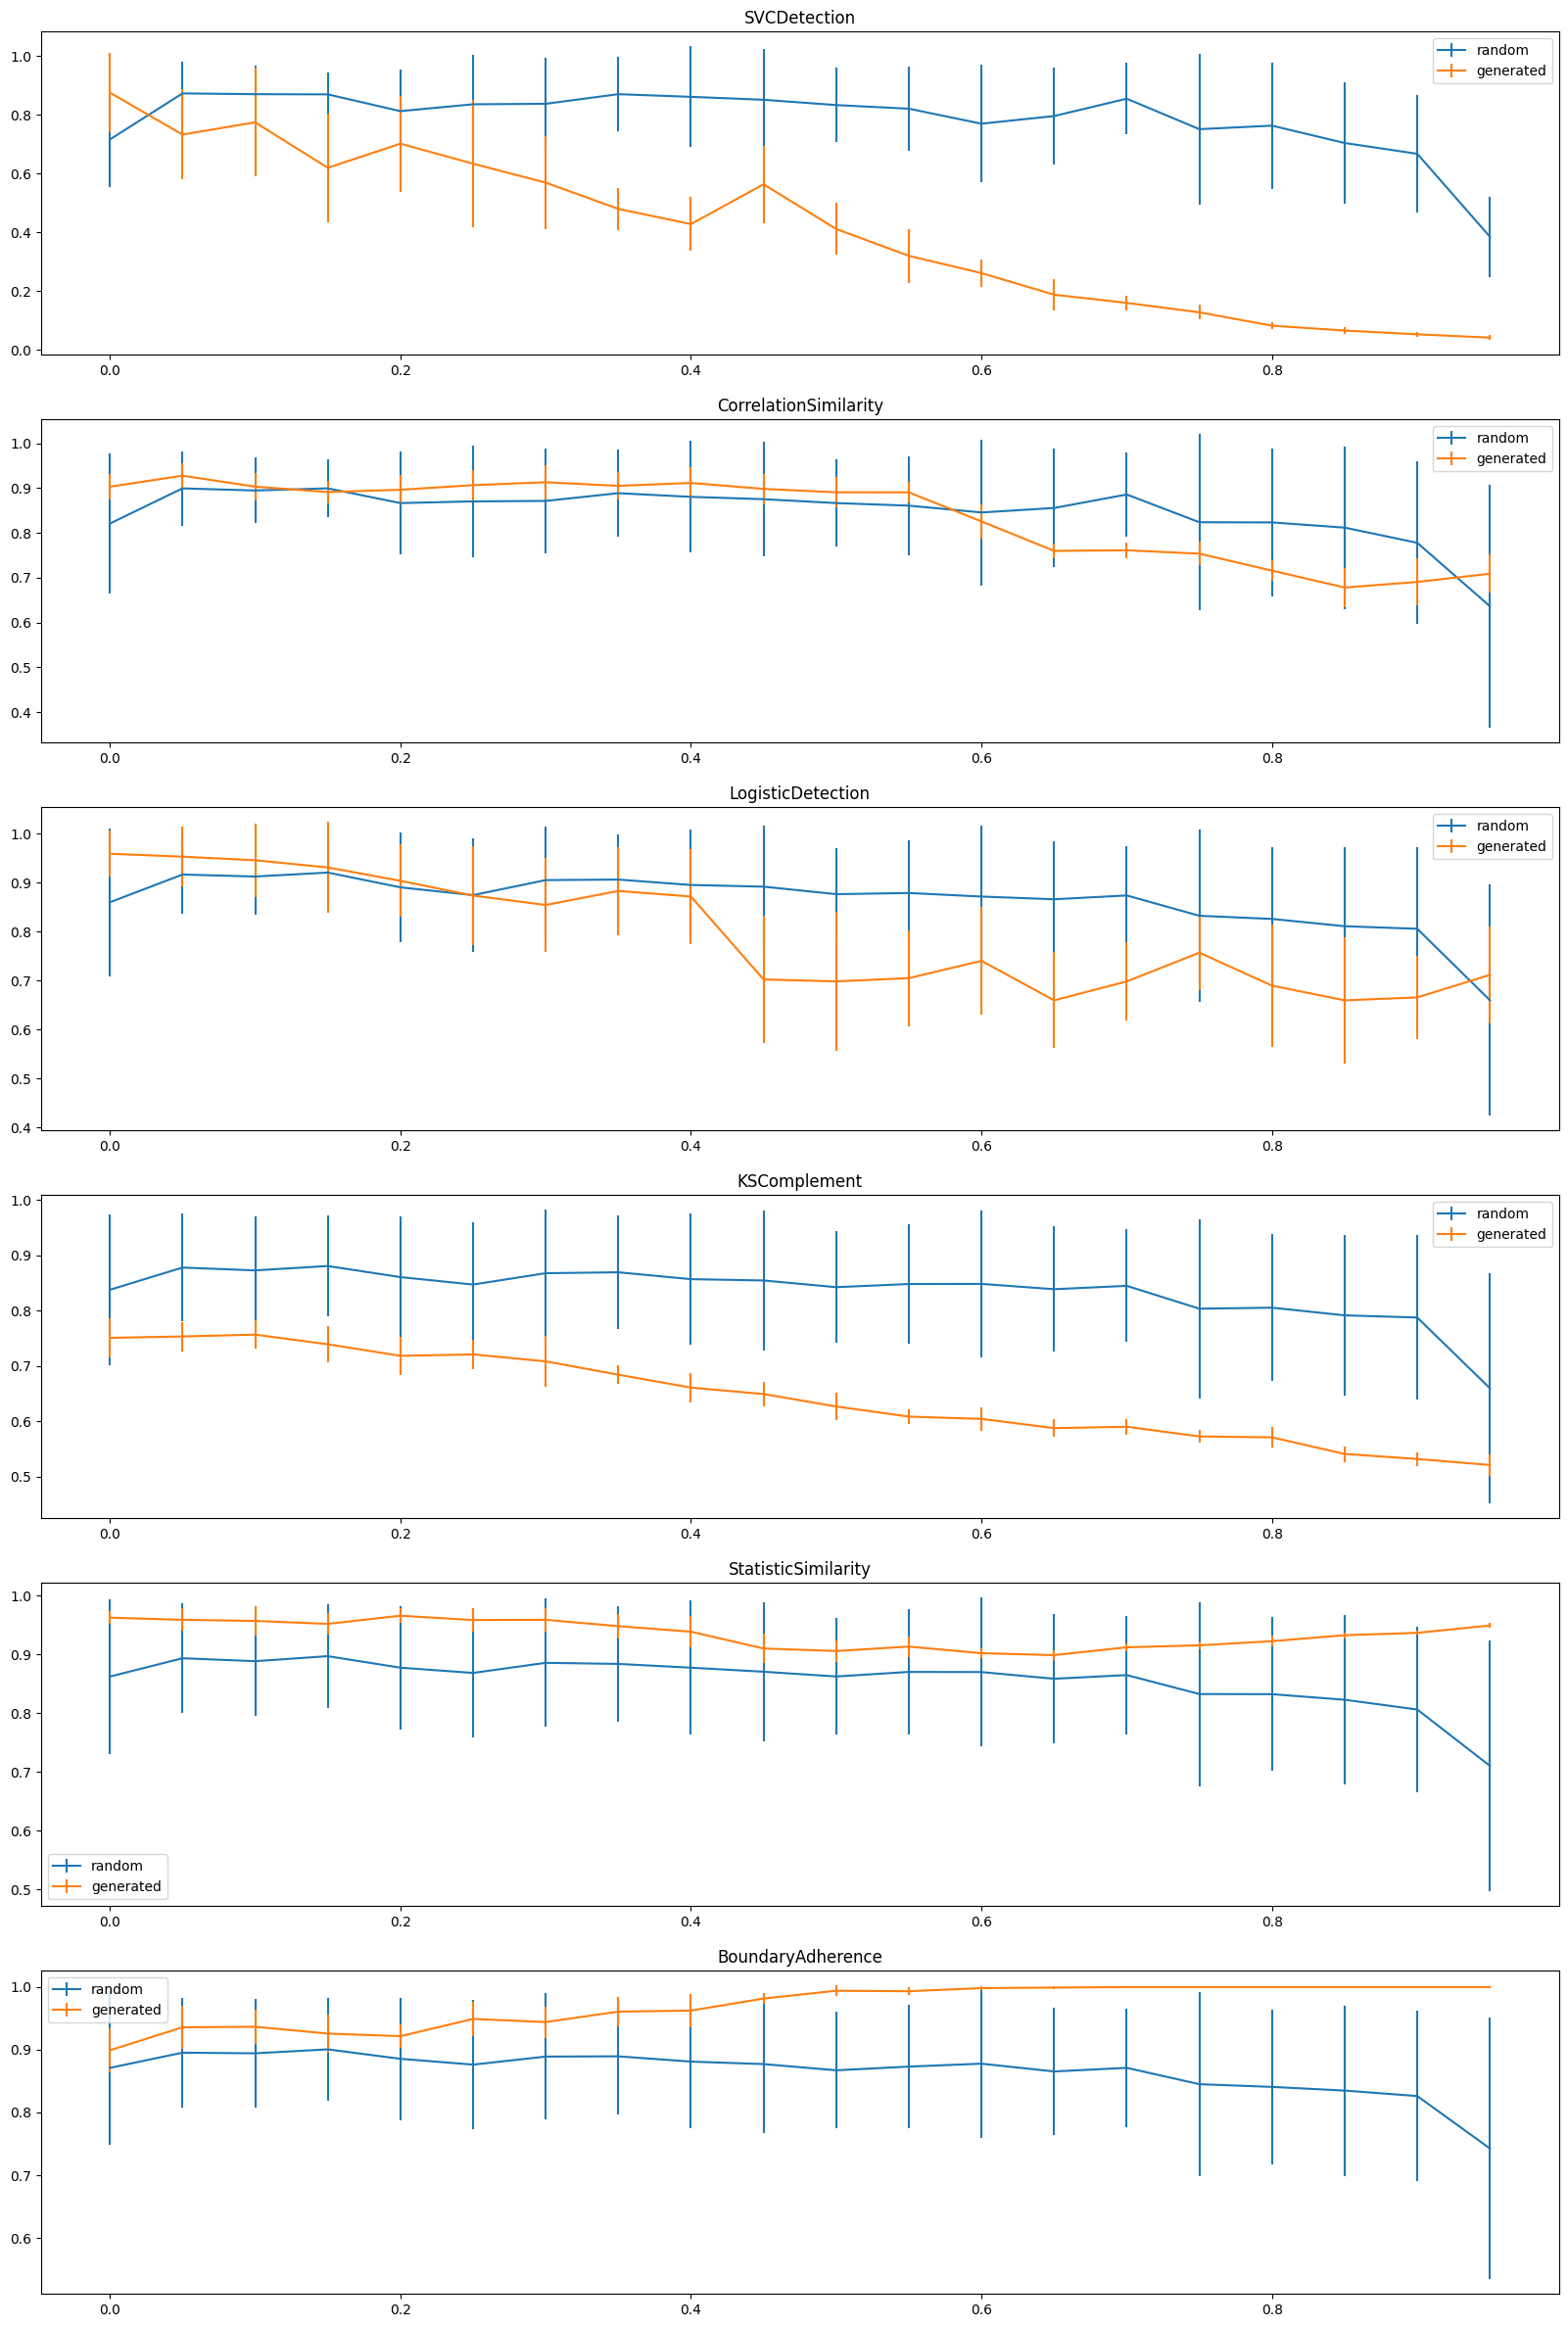

In [237]:
sorted_df = df.sort_values(ascending=True, by="values").drop(columns = ['values'])

fig, ax = plt.subplots(ncols=1, nrows = len(metric_list), figsize = [20,5*len(metric_list)])

random_score = {pct:[] for pct in percentages}

for i,metric in enumerate(metric_list):
    for pct in percentages:
        for k in range(n_iter_random):
            n_removal = int(pct * len(sorted_df))
            train_data = sorted_df.sample(int(len(sorted_df)-n_removal))#.iloc[n_removal:]
            model = m().fit(train_data)
            gen_data = model.sample(30)[0]
            
            score = metric.compute(
                    real_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
                    synthetic_data=pd.DataFrame(gen_data, columns = data.feature_names),
                )
            random_score[pct].append(score)
    
    ax[i].errorbar(x=percentages,y=[np.mean(x) for k,x in random_score.items()],
                        yerr=[np.std(x) for k,x in random_score.items()], label='random')

for i,metric in enumerate(metric_list):
    all_scores = {pct:[] for pct in percentages}
    for pct in percentages:
        n_removal = int(pct * len(sorted_df))
        train_data = sorted_df.iloc[n_removal:]
        model = m().fit(train_data)
        for k in range(n_iter):
            gen_data = model.sample(30)[0]
            score = metric.compute(
                    real_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
                    synthetic_data=pd.DataFrame(gen_data, columns = data.feature_names),
                )
            all_scores[pct].append(score)
    ax[i].errorbar(x=percentages,y=[np.mean(x) for k,x in all_scores.items()],
                    yerr=[np.std(x) for k,x in all_scores.items()], label='generated')
    ax[i].set_title(metric.__name__)
    ax[i].legend()
plt.show()

# TODO: CHECK WHY THE START OF RANDOM AND GENERATED ARE NOT EQUAL !!!!

## TWo samples test

## CS TEST

In [30]:
! python3 -m pip install sdmetrics

In [33]:
from sdmetrics.single_column import CSTest

In [45]:
j=3
CSTest.compute(real_data= utility.data.x_train[:,j], synthetic_data = utility.data.x_test[:,j])

0.0

In [56]:
data.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [57]:
from sdmetrics.single_table import LogisticDetection

LogisticDetection.compute(
    real_data=pd.DataFrame(utility.data.x_train, columns = data.feature_names),
    synthetic_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
)

1.0

## Compare with Loo

In [184]:
from sklearn.tree import DecisionTreeClassifier
from sdv.metrics.tabular import CSTest

In [68]:
all_scores = []
n_tries= 20
for i, x in df.iterrows():
    ov = x[-1]
    mean_score = 0
    for n in range(n_tries):
        train_set = df.drop(columns=['values']).sample(30)
        if(i in train_set.index):
            train_set = train_set.drop(i)
        mean_score += LogisticDetection.compute(
            real_data=train_set,
            synthetic_data=pd.DataFrame(utility.data.x_test, columns = data.feature_names),
        )
        
    all_scores.append(mean_score/n_tries)


In [ ]:
all_scores = []
n_tries= 20
for i, x in df.iterrows():
    ov = x[-1]
    mean_score = 0
    for n in range(n_tries):
        train_set = df.drop(columns=['values']).sample(100)
        if(i in train_set.index):
            train_set = train_set.drop(i)
        label_train_set = utility.data.y_train
        label_train_set = np.array(label_train_set)[train_set.index]
        eval_model = DecisionTreeClassifier().fit(train_set, label_train_set)
        mean_score += eval_model.score(data.x_test, data.y_test)
    all_scores.append(mean_score/n_tries)


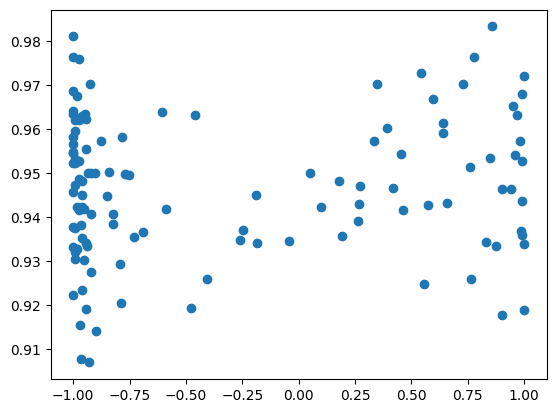

In [69]:
plt.scatter(df.loc[:,"values"], all_scores)

<Axes: xlabel='values'>

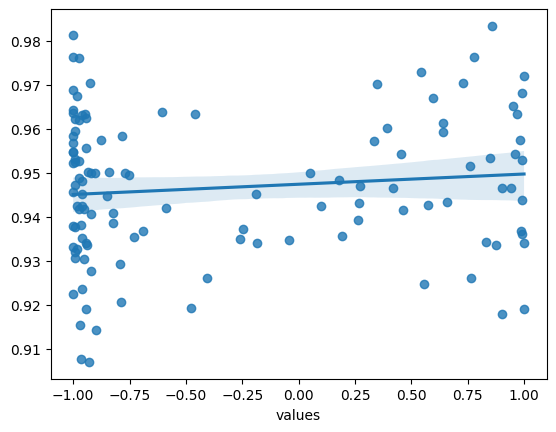

In [70]:
sns.regplot(x=df.loc[:,"values"], y=all_scores)

In [108]:
Plugins(categories=["generic"]).list()

[2023-09-25T14:23:25.557476+0200][12097][CRITICAL] module disabled: /home/bastienzim/Documents/pyDVL_DataOOB/venv/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-09-25T14:23:25.558924+0200][12097][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-09-25T14:23:25.559544+0200][12097][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-09-25T14:23:25.560441+0200][12097][CRITICAL] module plugin_great load failed


['dummy_sampler',
 'survival_nflow',
 'survae',
 'privbayes',
 'ddpm',
 'decaf',
 'marginal_distributions',
 'image_cgan',
 'survival_gan',
 'tvae',
 'survival_ctgan',
 'rtvae',
 'aim',
 'arf',
 'adsgan',
 'timegan',
 'nflow',
 'dpgan',
 'pategan',
 'timevae',
 'image_adsgan',
 'bayesian_network',
 'fflows',
 'radialgan',
 'uniform_sampler',
 'ctgan']